torch.Size([1, 1, 5650])


100%|██████████| 200/200 [00:27<00:00,  7.41it/s]


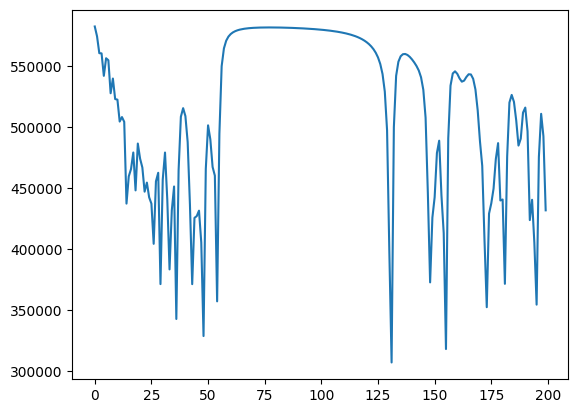

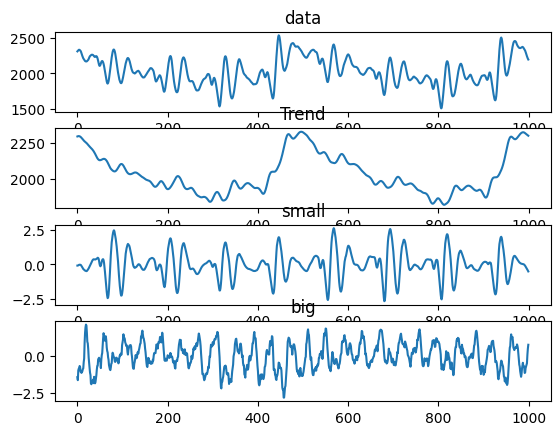

In [1]:
# 滤波
import signal_separation_model
import pandas as pd
import numpy as np
import torch
import matplotlib.pylab as plt

# 中值滤波降采样  1 1000
def avgpool(*,data,stride):
    length = data.shape[-1]
    ans = torch.zeros(1,1,int(length/stride)-2)
    for i in range(int(length/stride)-2):
        ans[0][0][i] = torch.sum(data[0][0][i*stride:i*stride+stride])/stride
    return ans

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# begin = 7500
# end = begin+25700
# # end = begin+30000
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/kansas_bcg1/pa6.csv'))[begin:end,9:10]
# data = np.array(pd.read_csv('/root/zqh/Getian/BCG_hy_2023-08-30.csv'))[begin:end, 1:2]

# begin = 7500
# end = begin+5700
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/ZQH040601bcg.csv'))[begin:end]
# data = np.array(pd.read_csv('/root/zqh/BCGOrigin_Data/ZQH0329.csv'))[begin:end]

begin = 8000
end = begin+5700
data = np.array(pd.read_csv('RawData1.csv'))[begin:end]

data = data.reshape(1,1,end-begin)
data = data.astype(np.float32)
data = torch.from_numpy(data)
# data = avgpool(data=data,stride=8) # Kansas数据预处理

data = data.view(1,1,data.shape[-1]).to(device) # 非 cuda

# 去趋势
deckernel_size = 51
avgpool1d = torch.nn.AvgPool1d(deckernel_size,stride=1)
T = avgpool1d(data) # 周期趋势
oral_data = data[:,:,deckernel_size//2 : data.shape[-1]-deckernel_size//2]
data = data[0][0][deckernel_size//2 : data.shape[-1]-deckernel_size//2] - T.squeeze(0).squeeze(0)
data = data.view(1,1,data.shape[-1])
print(data.shape)

# 模型训练
epoch = 200
model1 = signal_separation_model.predictNet(kernel_size1=7, kernel_size2=101, data_length=data.shape[-1]) # 非 cuda
model1 = signal_separation_model.trainPredictNet(model=model1,data=data,T=T,lr=0.0005,epoch=epoch)

output11, output22 = model1(data)
data = data.to(device)
output11 = output11.to(device)
output22 = output22.to(device)
showbegin = 1500
showend = 2500
plt.subplot(411)
plt.title("data")
plt.plot(oral_data[0][0][showbegin:showend])
plt.subplot(412)
plt.title("Trend")
plt.plot(T[0][0][showbegin:showend])
plt.subplot(413)
plt.title("small")
plt.plot(output11[0][0][showbegin:showend].detach().numpy())
plt.subplot(414)
plt.title("big")
plt.plot(output22[0][0][showbegin:showend].detach().numpy())
plt.show()
